# Optical Character Recognition
Saketh Raman KS (19PW26)

Sanjay T (19PW28)

## Introduction
The objective of the package is to use optical character recognition in order to read vehicle license plates and convert them to text.

## Localization of license plates

In [29]:
import os

IMAGE_FORMATS = ('.png', '.jpg', '.jpeg')

def get_image_files(path):
  files = os.listdir(path)
  imgFiles = [ x for x in files if x.lower().endswith(IMAGE_FORMATS) ]
  return imgFiles

def clear_folder(folder):
  for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    os.unlink(file_path)

def remove_extension(file):
  dotIndex = file.index('.')
  return file[ : dotIndex]
  

In [30]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def plot_images(image_list):
    fig = plt.figure(figsize = (30,10))
    rowNum = (len(image_list) // 3) + 1
    for i,j in enumerate(image_list):
        ax = fig.add_subplot(rowNum, 3, i+1)
        fn = image.load_img(j)
        plt.imshow(fn)
        plt.title(str(i+1))
        plt.axis('off')
    plt.show()

The below ObjectDetector class detects and returns objects labels from a given input images using the YOLO algorithm.

In [31]:

from imageai.Detection import ObjectDetection
import copy

YOLO_PATH = "./Models/yolo.h5"

class ObjectDetector:
    def __init__(self, input_path, output_path, min_prob):
        self.input_path = input_path
        self.output_path = output_path
        self.detector = ObjectDetection()
        self.min_prob = min_prob
        self.detections = {}
        
        self.detector.setModelTypeAsYOLOv3()
        self.detector.setModelPath(YOLO_PATH)

    def detect(self):
        self.detector.loadModel()
        clear_folder(self.output_path)
        
        for imgFile in get_image_files(self.input_path):
            input_image = os.path.join(self.input_path, imgFile)
            output_image = os.path.join(self.output_path, imgFile)
            det = self.detector.detectObjectsFromImage(input_image=input_image, output_image_path=output_image, minimum_percentage_probability=self.min_prob)
            self.detections[input_image] = det
    
    def get_detections(self):
        return self.detections
    
    def get_detection_labels(self):
        detected_labels = {}
        for file, detection in self.detections.items():
            labels = []
            for detection_dict in detection:
                labels.append(detection_dict["name"])
            
            detected_labels[file] = copy.deepcopy(labels)
        
        return detected_labels

In [32]:
carInputPath = "./Data/Image/Input"
carLabelledPath = "./Data/Image/Labelled"

objDet = ObjectDetector(carInputPath, carLabelledPath, 50)
objDet.detect()
detections = objDet.get_detection_labels()
print(detections)

{'./Data/Image/Input/street1.jpg': [], './Data/Image/Input/street2.jpg': ['traffic light'], './Data/Image/Input/street3.jpg': [], './Data/Image/Input/MH20DV2363.jpg': ['car', 'car', 'car', 'car', 'car'], './Data/Image/Input/MH20DV2366.jpg': ['car', 'car', 'car'], './Data/Image/Input/UK07AW2153.jpg': ['car', 'truck'], './Data/Image/Input/DL8CAF5030.jpeg': ['car'], './Data/Image/Input/MH01AV8866.jpeg': ['car'], './Data/Image/Input/DL7CQ1939.jpg': ['truck', 'truck', 'car', 'car']}


### Images before filtering

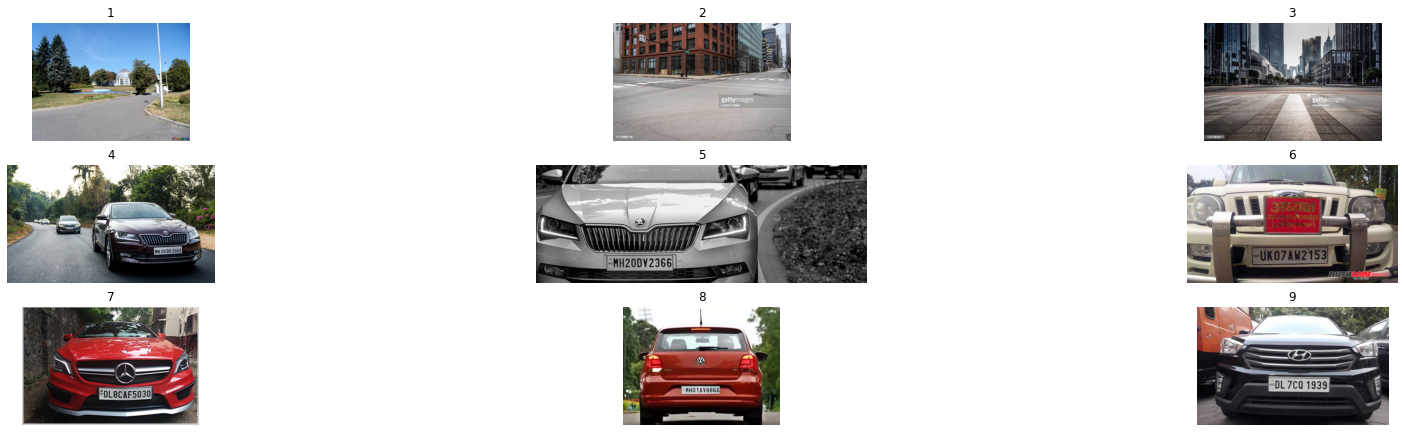

In [33]:
plot_images(list(detections.keys()))

Filtering

The image files which contain relevant labels are filtered and copied to a different location

In [34]:
FILTER_LABELS = ("car", "bus", "truck", "motorcycle")

filtered_files = []
for file, file_labels in detections.items():
  for filter_label in FILTER_LABELS:
    if filter_label in file_labels:
      filtered_files.append(file)
      break

### Images after filtering

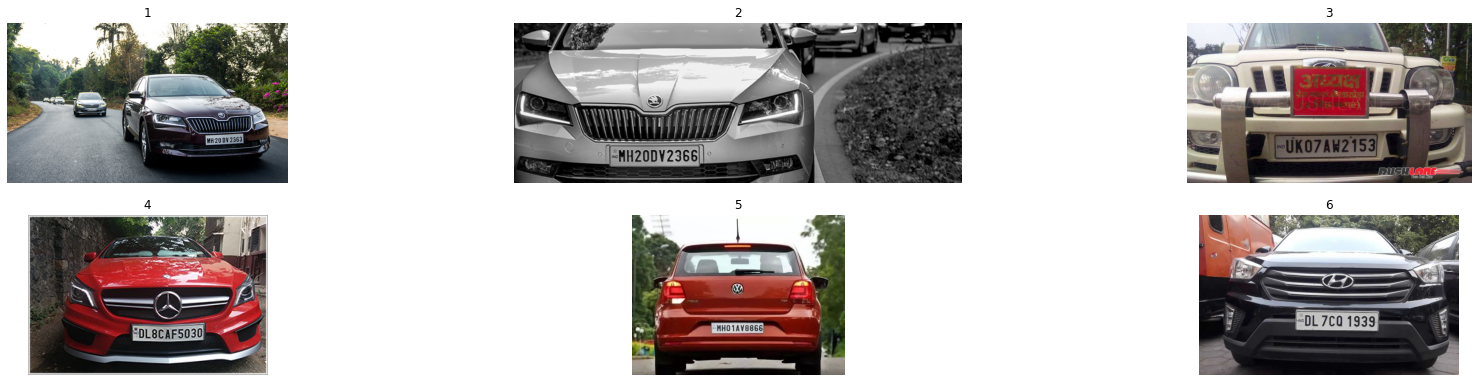

In [35]:
plot_images(filtered_files)

### Filtered images with bounding boxes

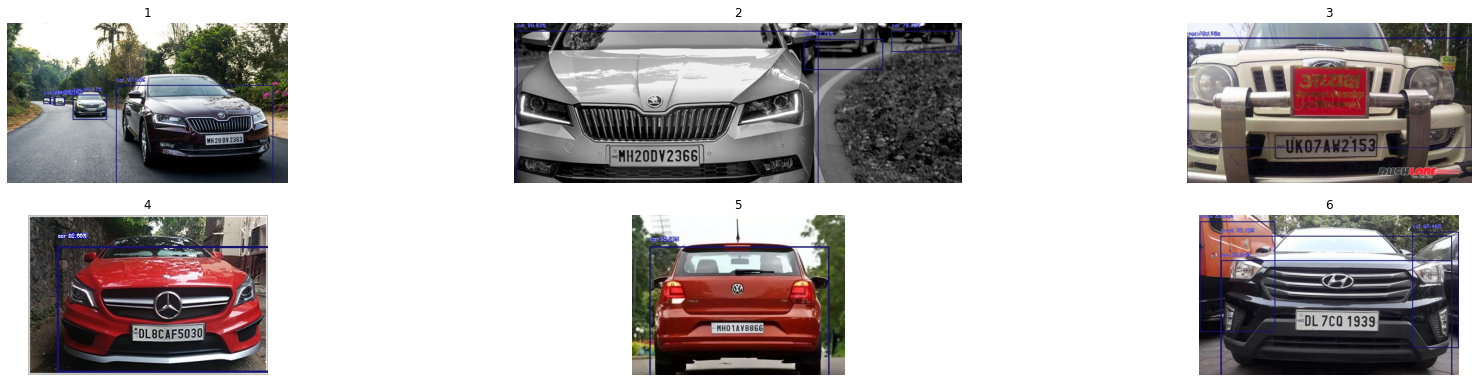

In [36]:
labelledImages = [ os.path.join(carLabelledPath, os.path.basename(filteredFileName)) for filteredFileName in filtered_files ]
plot_images(labelledImages)

In [37]:
import shutil

CAR_FOLDER = "./Data/Car"

for filename in filtered_files:
  file_basename = os.path.basename(filename)
  copied_file_path = os.path.join(CAR_FOLDER, file_basename)
  shutil.copy(filename, copied_file_path)

### Locating License Plates

In order to locate the license plate in the image, an approach based on the Viola Jones algorithm is used. The Viola - Jones algorithm is commonly used for facial recognition.

In [38]:
CASCADE_PATH = "./Models/numberplate.xml"

class CascadeClassifier:
  def __init__(self, image, min_neighbors):
    self.image = image
    self.classifier = cv2.CascadeClassifier(CASCADE_PATH)
    self.min_neighbors = min_neighbors
  
  def detect_cascade(self):
    self.coords = self.classifier.detectMultiScale(self.image, self.min_neighbors)
  
  def get_coords(self):
    return self.coords
  
  def get_plate(self):
    print(self.coords)
    coord = self.coords[0]
    x, y, w, h = coord
    plate = self.image[y : y + h, x : x + w]
    return plate

In [39]:
import matplotlib.pyplot as plt
import cv2

PLATE_FOLDER = "./Data/Plate/"

for carFile in get_image_files(CAR_FOLDER):
  carPath = os.path.join(CAR_FOLDER, carFile)
  carImg = cv2.imread(carPath)
  cc = CascadeClassifier(carImg, 1.2)
  cc.detect_cascade()
  plate = cc.get_plate()
  outPath = os.path.join(PLATE_FOLDER, carFile)
  cv2.imwrite(outPath, plate)

[[678 374 146  49]]
[[262 351 347 116]]
[[327 461 549 183]]
[[133 138 125  41]]
[[160 212 141  47]]
[[283 278 333 111]]


### Cropped license plates

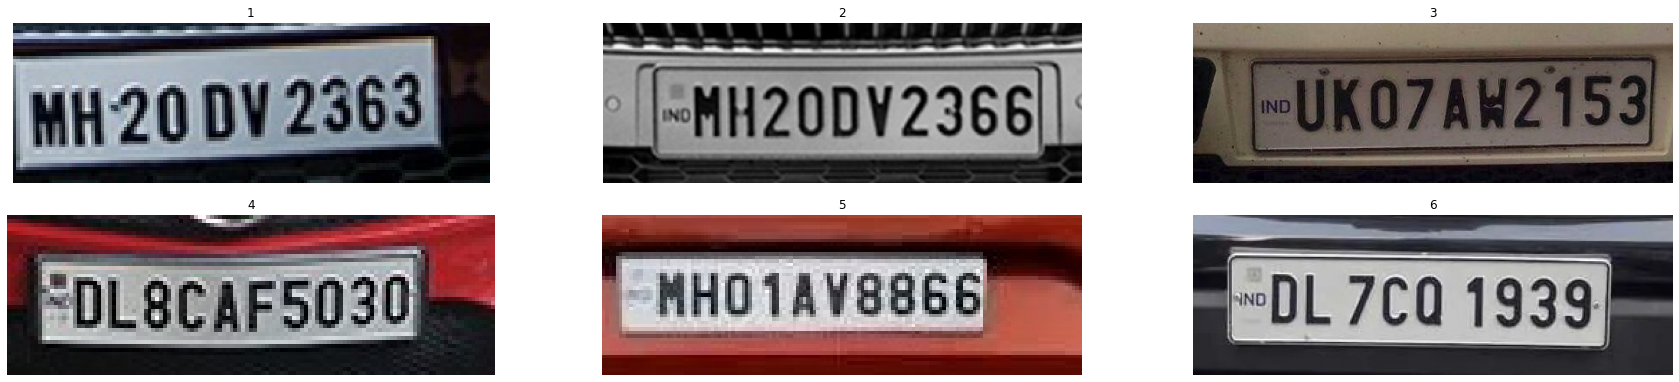

In [40]:
fullPlateImagePath = [ os.path.join(PLATE_FOLDER, plateFileImage) for plateFileImage in get_image_files(CAR_FOLDER) ]
plot_images(fullPlateImagePath)

## Character Recognition

In [41]:
class ImageProcess:

    @staticmethod
    def get_grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    @staticmethod
    def remove_noise(image):
        return cv2.medianBlur(image, 5)

    @staticmethod
    def thresholding(image):
        return cv2.threshold(image, 0, 255,  cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [42]:
plateImg = {}
for plateFile in get_image_files(PLATE_FOLDER):
  plateImgPath = os.path.join(PLATE_FOLDER, plateFile)
  plateImg[remove_extension(plateFile)] = cv2.imread(plateImgPath)

### Average image of license plates

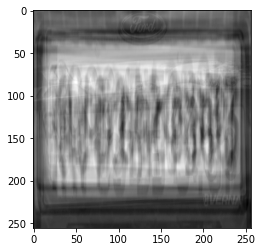

In [44]:
import numpy as np

avg_image = np.zeros((256, 256))
for image in plateImg.values():
  image = cv2.resize(ImageProcess.get_grayscale(image), (256, 256))
  avg_image += image
avg_image /= len(plateImg.values())
plt.imshow(avg_image, cmap="gray")

### Tesseract-OCR

Tesseract OCR is an open source optical character recognition tool maintained by Google. The license plate images are provided to Tesseract in order to recognize the characters.

In [45]:
import pytesseract as pt
from pytesseract import Output

class ImageRecognizer:
    def __init__(self, image, *, psm=6, char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"):
        self.image = image
        self.config = f"--psm {psm} tessedit_char_whitelist = {char_whitelist}"
        self.processed = False

    def recognize(self):
        self.boxes = pt.image_to_boxes(
            self.image, config=self.config, output_type=Output.DICT)
        self.data = pt.image_to_data(
            self.image, config=self.config, output_type=Output.DICT)
        self.text = pt.image_to_string(self.image, config=self.config)
        self.processed = True

    def get_text(self):
        if not self.processed:
            return False
        return self.text

    def get_boxes(self):
        if not self.processed:
            return False
        return self.boxes

    def get_data(self):
        if not self.processed:
            return False
        return self.data

In [46]:
tesseract_output = {}
for file, img in plateImg.items():
  # img = ImageProcess.get_grayscale(img)
  # img = ImageProcess.thresholding(img)
  ir = ImageRecognizer(img)
  ir.recognize()
  tesseract_output[file] = ir.get_text()

print(tesseract_output)

{'AS01AZ7873': 'IASG1AZ7873\n\x0c', 'CG04MF2250': '[ _CC04MF2250\n\x0c', 'DL2CK8169': '% DL 2C K8169\n\x0c', 'DL7CQ1939': '~DL 7CQ 1939\n\x0c', 'DL8CAF5030': '-DL8CAF5030]\n\x0c', 'GJ03ER0563': '+6J03ER0563]\n\x0c', 'KL52P3003': 'KL 52 P_3003]\n\x0c', 'MH01AV8866': 'MHO1AVB866)\n\x0c', 'MH12DE1433': 'MH12DE1433]\n\x0c', 'MH20DV2363': 'MH 20DV 2363I\n\x0c', 'MH20DV2366': 'w\n<MH20DY2366|]\n\x0c', 'MH20EJ0365': 'MH20EJ 0365\n\x0c', 'TN63DB5481': '‘I TN 63 DB 5481 |\n\x0c', 'UK07AW2153': ') [~UK07ANZ2153\n\x0c'}


A fuzzy search is used to extract the license plate from the output.

In [47]:
import regex

NUMERPLATE_PATTERN=regex.compile(
    r"(([A-Z]\s*){2}([0-9]\s*){1,2}([A-Z]\s*){2}([0-9]\s*){1,4}){s<2}")
    
def get_numberplate_matches(text):
  matches = NUMERPLATE_PATTERN.findall(text)
  return matches

In [48]:
count = 0
matched_output = {}
for file, output in tesseract_output.items():
  match = get_numberplate_matches(output)
  if len(match) == 0:
    count += 1
  else:
    matched_output[file] = match[0][0].strip()

print(f"Unmatched: {count} Total: {len(tesseract_output)}")
print(matched_output)

Unmatched: 0 Total: 14
{'AS01AZ7873': 'ASG1AZ7873', 'CG04MF2250': 'CC04MF2250', 'DL2CK8169': 'DL 2C K8169', 'DL7CQ1939': 'DL 7CQ 1939', 'DL8CAF5030': 'DL8CAF5030', 'GJ03ER0563': '6J03ER0563', 'KL52P3003': 'KL 52 P_3003', 'MH01AV8866': 'HO1AVB866', 'MH12DE1433': 'MH12DE1433', 'MH20DV2363': 'MH 20DV 2363', 'MH20DV2366': 'MH20DY2366', 'MH20EJ0365': 'MH20EJ 0365', 'TN63DB5481': 'I TN 63 DB 5481', 'UK07AW2153': 'UK07ANZ2153'}


## Performance Measures

In [49]:
import nltk

def get_distance(str1, str2):
  str2 = [ c for c in str2 if c.isalnum() ]
  return nltk.edit_distance(str1, str2)

In [50]:
edit_distances = {}
for file, prediction in matched_output.items():
  edit_distances[file] = get_distance(file, prediction)

[1, 1, 0, 0, 0, 1, 0, 3, 0, 0, 1, 0, 1, 2]


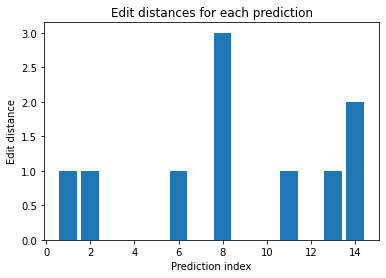

In [51]:
errors = list(edit_distances.values())
print(errors)
barX = list(range(1, len(errors) + 1))

fig, ax = plt.subplots()
ax.bar(barX, errors)
ax.set_title("Edit distances for each prediction")
ax.set_xlabel("Prediction index")
ax.set_ylabel("Edit distance")
plt.show()

In [52]:

print("Mean of incorrect characters: ", np.mean(errors))
print("Standard deviation of incorrect characters: ", np.std(errors))
print("Median of incorrect characters: ", np.median(errors))

Mean of incorrect characters:  0.7142857142857143
Standard deviation of incorrect characters:  0.8806305718527108
Median of incorrect characters:  0.5


## Challenges faced and Conclusion
The following challenges were faced while building the system:

1. Availability of quality data: Finding high quality iamges of cars with readable numberplates was a difficult process.
2. Accuracy of Tesseract-OCR: The output of Tesseract-OCR was not close to the actual text in images with lighting differences, and those where the license plate was not aligned horizontally.

In conclusion, such systems may be deployed in order to automate the process of reading the numberplates of cars using CCTV cameras.